# Sub-task 2.1:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture #For GMM clustering

In [2]:
df= pd.read_csv('cluster1.csv', names=['X', 'Y'])

## 2.1: Kmeans

#### Set Params

In [3]:
k = 3 #number of clust centres
initial = 'k-means++' #initialise with k-m++
num_iter = 2
X = df.to_numpy().reshape(len(df), -1)

#### Train and Get Data

In [4]:
km = KMeans(n_clusters=k, init=initial, max_iter=num_iter).fit(df)
clust_labels = km.predict(df) #get the labels
cen = km.cluster_centers_ #get the cluster centres

kmeans = pd.DataFrame(clust_labels) #store labels
df.insert((df.shape[1]), 'kmeans', kmeans)

#### Plot

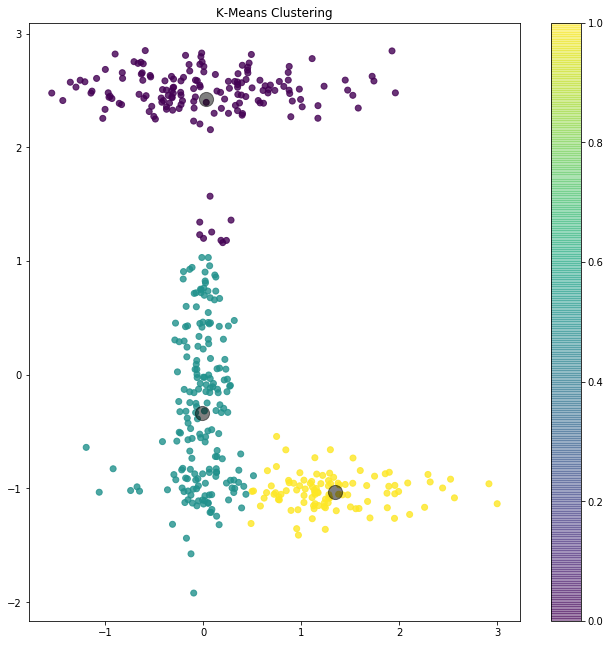

In [5]:
fig = plt.figure(figsize=[11,11])
ax = fig.add_subplot(111)
scatter = ax.scatter(X[:, 0], X[:, 1], c = kmeans[0], alpha=0.8)
scatter = ax.scatter(cen[:,0], cen[:,1], c="black", s=200, alpha = 0.5)
                     
ax.set_title('K-Means Clustering')
plt.colorbar(scatter)

## 2.1: Guassian Mixture Model

In [6]:
gmm = GaussianMixture(n_components=3).fit(X)
probs = gmm.predict_proba(X)
labels = gmm.predict(X)

In [7]:
gmmres = pd.DataFrame(labels)
df.insert((df.shape[1]), 'GMM', gmmres)

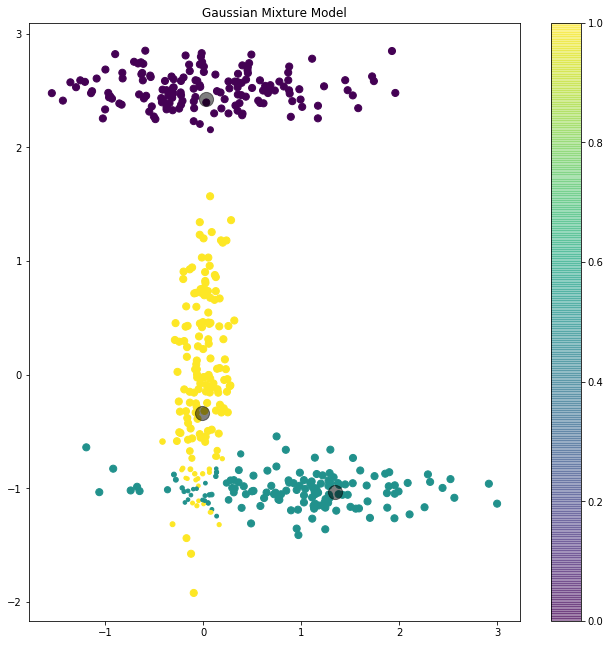

In [8]:
fig = plt.figure(figsize=[11,11])
ax = fig.add_subplot(111)
size = 50 * probs.max(1) ** 2  # square emphasizes differences

scatter = ax.scatter(X[:, 0], X[:, 1], c=gmmres[0], s=size)
scatter = ax.scatter(cen[:,0], cen[:,1], c="black", s=200, alpha = 0.5)
ax.set_title('Gaussian Mixture Model')
plt.colorbar(scatter)

### Nice Visualization of Boundaries
https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

In [9]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

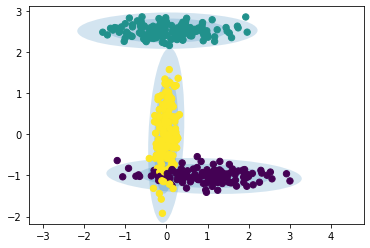

In [10]:
gmm = GaussianMixture(n_components=3)
plot_gmm(gmm, X)

## 2.1: Analysis
- Different, as K-means enforces a circular structure whereas Gaussian does not, clear to see that the clusters cant be described too well by a circle through the intersection between the bottom two, and the missclassification of the top of the central grouping of data.
- This issue becomes more evident when the distribution outlines are shown on the GMM, its non circular geometry easily allows for the data to be better split over 3 clusters.
- Naturally this correlates with how the GMM is calculated, instead using the probability of each sample belonging to a cluster (using the distribution), rather than the hard assignment in K-means

# Sub-task 2.2:
## K-Means Elbow

In [11]:
c2 = pd.read_csv('cluster2.csv', names=['X', 'Y'])
X = c2.to_numpy().reshape(len(c2), -1)
kmax = 8

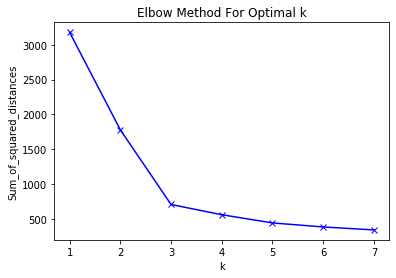

In [12]:
sum_squared_distances = []
K = range(1,kmax)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    sum_squared_distances.append(km.inertia_) #Sum of squared distances of samples to their closest cluster center attrib

plt.plot(K, sum_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### 2.2: Elbow Analysis
* Elbow score uses sum of squared errors, showing the trend that as more clusters are added the error decreases. Elbow highlights where the addition of further clusters has diminishing returns. Using the Elbow Score __3 clusters__ Looks like a great candidate. Through research its suggested that a silhouette score could be used to confirm this. 

## K-Means Silhouette Validation
Sklearn Provides code for visualizing these scores: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For n_clusters = 2 The average silhouette_score is : 0.44229037880472927
For n_clusters = 3 The average silhouette_score is : 0.5738307485410833
For n_clusters = 4 The average silhouette_score is : 0.49295919038134617


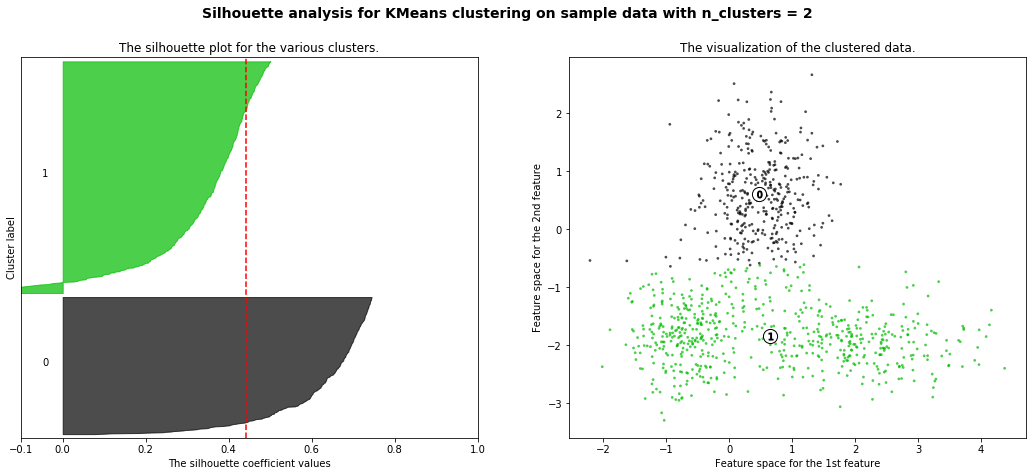

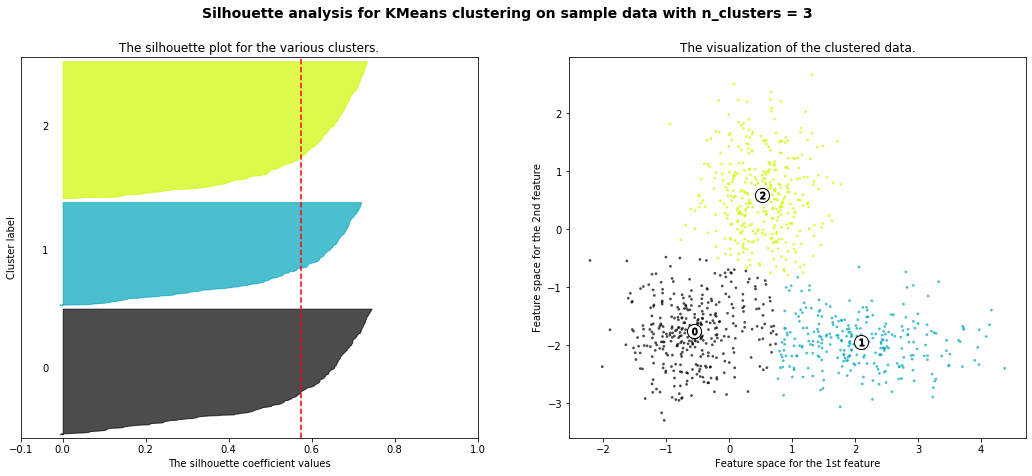

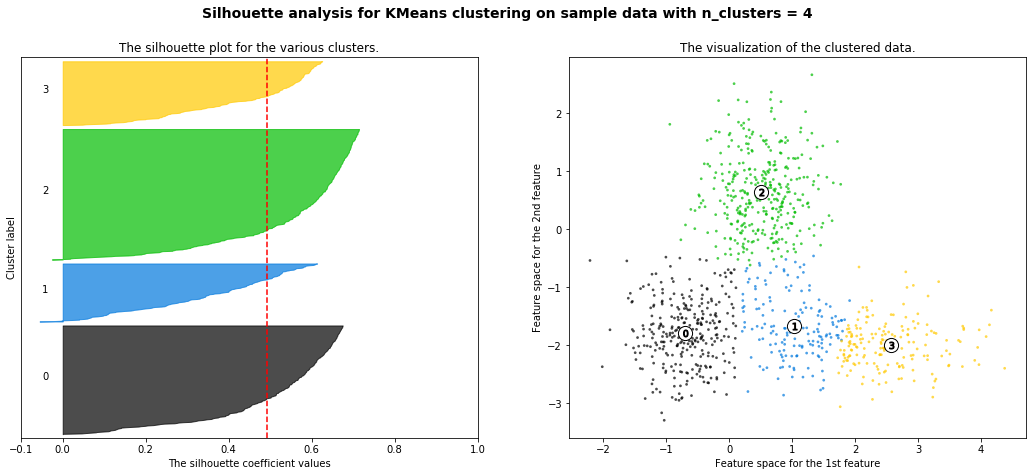

In [13]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### 2.2: Silhouette Analysis
* The Silhouette method validates the elbow method with 3 clusters being the most optimal. The silhouette method functions by measuring how close each point in one cluster is to the points in the neighbouring cluster, the further away, the higher the score. Higher score indicating that there is no overlap (which would occur with too many clusters).
- The thickness of the silhouette shows the density or number of points in that cluster, visually representing that the points are relatively evenly distributed among the clusters in k=3 

# 2.2: Final Model

In [14]:
km = KMeans(n_clusters=3).fit(X)
clust_labels = km.predict(X) #get the labels
cen = km.cluster_centers_ #get the cluster centres

kmeans = pd.DataFrame(clust_labels) #store labels
c2.insert((c2.shape[1]), 'kmeans', kmeans)

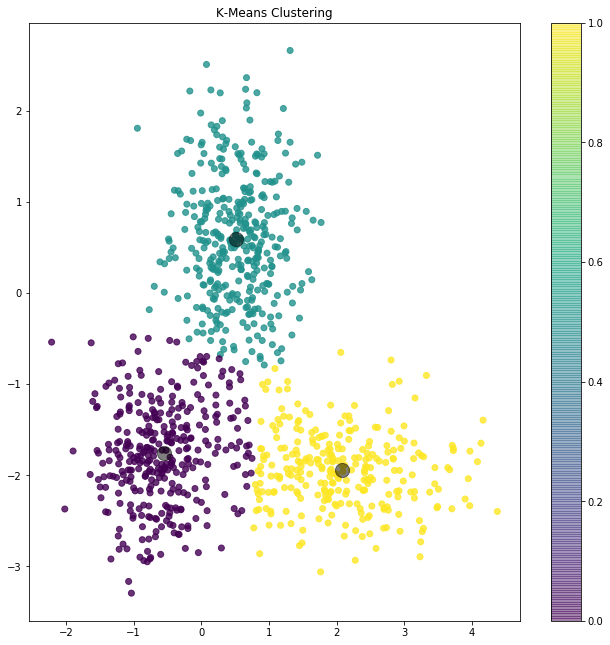

In [15]:
fig = plt.figure(figsize=[11,11])
ax = fig.add_subplot(111)
scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans[0], alpha=0.8)
scatter = ax.scatter(cen[:,0], cen[:,1], c="black", s=200, alpha = 0.5)
                     
ax.set_title('K-Means Clustering')
plt.colorbar(scatter)